In [1]:
import pandas as pd
import numpy as np

In [2]:
from dataclasses import dataclass
rng = np.random.default_rng()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


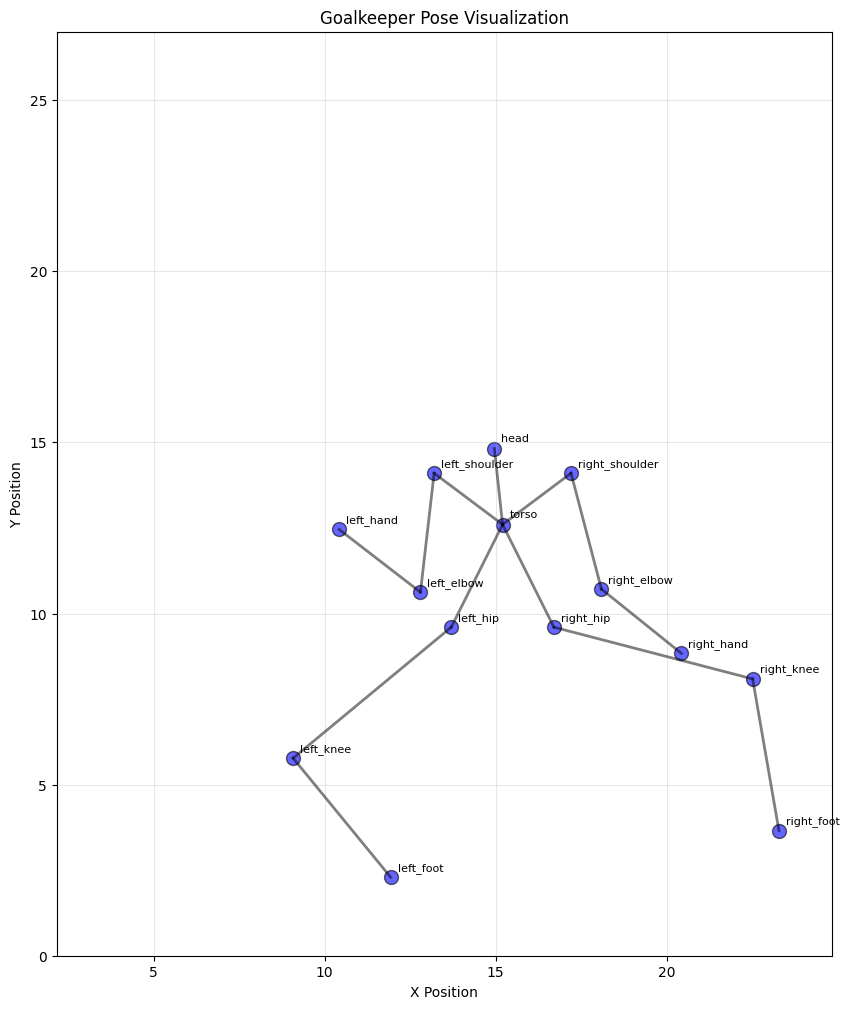

In [3]:
from physicsbasedposes import generate_pose, evaluate_save

# Shots Table

In [4]:
df = pd.read_excel("Synthetic Data.xlsx", sheet_name=1)
df.head()

,type,x,y,appearance
0,Jump,0,7,0
1,Standing,25,25,0
2,Dive,18,7,0
3,Wing,11,7,0
4,Lob,9,1,2


In [5]:
def generate_synthetic(df, n_rows, schema):
    synthetic = pd.DataFrame(index=range(n_rows))
    start_time=pd.Timestamp("2026-01-01 00:00")

    for col in schema:
        synthetic[col.name] = rng.integers(
            size=n_rows,
            **col.params
        )
    
    synthetic["velocity"] = rng.lognormal(mean=4.55, sigma=0.16, size=n_rows)
    
    for col in df.select_dtypes(exclude=np.number):
        freq = df[col].value_counts(normalize=True)
        synthetic[col] = rng.choice(
            freq.index,
            size=n_rows,
            p=freq.values
        )

    synthetic["timestamp"] = start_time + pd.to_timedelta(
        rng.uniform(0, 3600, size=n_rows),
        unit="s"
    )
    
    return synthetic

In [6]:
@dataclass
class ColumnDescription:
    name: str
    params: dict

schema = [
    ColumnDescription("appearance", {"low": 0, "high": 25}),
    ColumnDescription("x", {"low": 0, "high": 27}),
    ColumnDescription("y", {"low": 0, "high": 27}),
    ColumnDescription("shooter", {"low": 0, "high": 40}),
]

In [7]:
synth = generate_synthetic(df, n_rows=500, schema=schema)
synth["time"] = synth["timestamp"].dt.time
synth["velocity"] = np.floor(synth["velocity"])
synth = synth.sort_values(by=["appearance", "time"]).reset_index(drop=True)
synth.insert(0, "shot_id", np.arange(len(synth), dtype=int))
synth.head(20)

,shot_id,appearance,x,y,shooter,velocity,type,timestamp,time
0,0,0,22,15,39,98.0,Bounce,2026-01-01 00:00:14.892157453,00:00:14.892157
1,1,0,7,8,13,94.0,Dive,2026-01-01 00:00:15.189135086,00:00:15.189135
2,2,0,5,3,26,95.0,Standing,2026-01-01 00:00:22.173474818,00:00:22.173474
3,3,0,22,10,17,92.0,Jump,2026-01-01 00:00:55.499276502,00:00:55.499276
4,4,0,22,4,15,139.0,Standing,2026-01-01 00:02:54.870477066,00:02:54.870477
5,5,0,9,8,0,111.0,Wing,2026-01-01 00:05:50.479486481,00:05:50.479486
6,6,0,24,7,0,86.0,Underarm,2026-01-01 00:09:59.408694329,00:09:59.408694
7,7,0,23,8,15,75.0,Lob,2026-01-01 00:11:54.499983321,00:11:54.499983
8,8,0,10,2,12,79.0,Underarm,2026-01-01 00:13:11.404225766,00:13:11.404225
9,9,0,11,1,2,77.0,Lob,2026-01-01 00:18:21.069422762,00:18:21.069422


In [8]:
synth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   shot_id     500 non-null    int64         
 1   appearance  500 non-null    int64         
 2   x           500 non-null    int64         
 3   y           500 non-null    int64         
 4   shooter     500 non-null    int64         
 5   velocity    500 non-null    float64       
 6   type        500 non-null    object        
 7   timestamp   500 non-null    datetime64[ns]
 8   time        500 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 35.3+ KB


In [9]:
BODY_NODES = [
    'torso', 'head',
    'left_shoulder', 'left_elbow', 'left_hand',
    'left_hip', 'left_knee', 'left_foot',
    'right_shoulder', 'right_elbow', 'right_hand',
    'right_hip', 'right_knee', 'right_foot'
]

for node in BODY_NODES:
    synth[f'{node}_x'] = 0.0
    synth[f'{node}_y'] = 0.0
synth['isgoal'] = False

for idx, row in synth.iterrows():
    shot_coords = [row['x'], row['y']]
    pose = generate_pose(shot_coords)
    
    save_result = evaluate_save(pose, shot_coords, radius=1.0)
    synth.at[idx, 'isgoal'] = not save_result['saved']  # Goal = NOT saved
    
    for node in BODY_NODES:
        synth.at[idx, f'{node}_x'] = pose[node]['x']
        synth.at[idx, f'{node}_y'] = pose[node]['y']

print(f"Added {len(BODY_NODES) * 2} pose columns and 'isgoal' column to synth DataFrame")
print(f"Goals: {synth['isgoal'].sum()}, Saves: {(~synth['isgoal']).sum()}")

Added 28 pose columns and 'isgoal' column to synth DataFrame
Goals: 127, Saves: 373


In [ ]:
synth["velocity"].hist(bins=30)

In [ ]:
synth.head()

# Shooters Table

In [ ]:
shooters_df = synth.groupby("shooter")["isgoal"].sum().reset_index(name="total_goals")

In [14]:
shooters_df = (
    synth.groupby(["shooter", "type"])
         .agg(
             shots=("isgoal", "size"),
             goals=("isgoal", "sum")
         )
         .reset_index()
)
shooters_df = shooters_df.pivot(index="shooter", columns="type", values=["shots", "goals"]).fillna(0)
shooters_df.columns = [f"{metric}_{shot_type}" for metric, shot_type in shooters_df.columns]
shooters_df = shooters_df.reset_index()
shooters_df.head()

,shooter,shots_Bounce,shots_Dive,shots_Hip,shots_Jump,shots_Lob,shots_Spin,shots_Standing,shots_Underarm,shots_Wing,goals_Bounce,goals_Dive,goals_Hip,goals_Jump,goals_Lob,goals_Spin,goals_Standing,goals_Underarm,goals_Wing
0,0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
1,1,0.0,1.0,2.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,1.0,2.0,2.0,1.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,3,1.0,1.0,1.0,2.0,1.0,3.0,6.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
4,4,1.0,1.0,1.0,3.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Appearances Table

In [15]:
app_df = (
    synth
    .groupby("appearance")["isgoal"]
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)
app_df = app_df.rename(
    columns={True: "conceded", False: "saved"}
).rename_axis(None, axis=1)
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   appearance  25 non-null     int64
 1   saved       25 non-null     int64
 2   conceded    25 non-null     int64
dtypes: int64(3)
memory usage: 732.0 bytes


In [16]:
n_players = 4

player_ids = np.arange(0, n_players)
player_probs = np.array([0.5, 0.25, 0.15, 0.1], dtype=float)
player_probs = player_probs / player_probs.sum()
app_df["player_id"] = rng.choice(player_ids, size=len(app_df), p=player_probs)

app_df["match_id"] = rng.integers(0, 23, size=len(app_df))

# Players Table

In [ ]:
player_df = app_df.groupby("player_id")[["saved", "conceded"]].sum().reset_index()
player_df.info()

# Matches Table

In [ ]:
match_df = app_df.groupby("match_id")["conceded"].sum().reset_index(name="conceded")

opponents = ["Fábrica de Azulejos Coentrão", "Comunidade Judaica de Vila Real", "Sporting Clube de Cascos de Rolha", "Associação Desportiva de Cascos de Rolha"]
match_df["opponent"] = rng.choice(opponents, size=len(match_df))
match_df["scored"] = rng.integers(5, 26, size=len(match_df))
match_df.head(10)

In [ ]:
with pd.ExcelWriter("output.xlsx") as writer:
    synth.to_excel(writer, sheet_name="Shots", index=False)
    app_df.to_excel(writer, sheet_name="Appearances", index=False)
    player_df.to_excel(writer, sheet_name="Players", index=False)
    match_df.to_excel(writer, sheet_name="Matches", index=False)
    shooters_df.to_excel(writer, sheet_name="Shooters", index=False)